## get the data from the bucket

In [1]:
import xarray as xr
import s3fs
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", client_kwargs=dict(endpoint_url="https://rgw.met.no"))

In [2]:
s3

### Read and plot regional averages for the Barents Sea region

In [5]:
# load useful packages
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import s3fs
%matplotlib inline

### Set Bucket details

In [6]:
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", client_kwargs=dict(endpoint_url="https://rgw.met.no"))

### open CMIP6 online catalog and read the areacello data for NorESM2-LM

In [7]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(source_id=['NorESM2-LM'], activity_id = ['CMIP'], experiment_id=['piControl'], table_id=['Ofx'], variable_id=['areacello'], member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCC,NorESM2-LM,piControl,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/piControl...,NaN,20210118


In [8]:
ds_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [9]:
areacello = ds_dict[list(ds_dict.keys())[0]]

#### Remove excess dimensions (i.e. member_id in this case)

In [10]:
areacello = areacello.squeeze()
areacello

<xarray.Dataset>
Dimensions:             (j: 385, i: 360, vertices: 4)
Coordinates:
  * i                   (i) int32 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
  * j                   (j) int32 1 2 3 4 5 6 7 ... 379 380 381 382 383 384 385
    latitude            (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    member_id           <U8 'r1i1p1f1'
Dimensions without coordinates: vertices
Data variables:
    areacello           (j, i) float32 dask.array<chunksize=(385, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(385, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(385, 360, 4), meta=np.ndarray>
Attributes: (12/53)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             branch-restart from year 1600-01-01 of piContr...
    branch_time:               0.0
    branch_time_in_child:      430335.0
    branch_time_in_parent:     430335.0
    ...                        ...
    tracking_id:               hdl:21.14100/9996266f-aa0a-4de1-99ab-a9d732773b15
    variable_id:               areacello
    variant_label:             r1i1p1f1
    version_id:                v20210118
    intake_esm_varname:        ['areacello']
    intake_esm_dataset_key:    CMIP.NCC.NorESM2-LM.piControl.Ofx.gn

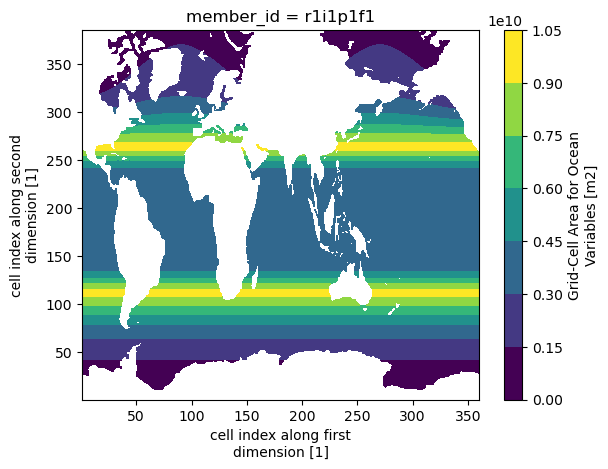

In [11]:
areacello.areacello.plot.contourf()

### The ocean grid is a bit strange in the Arctic

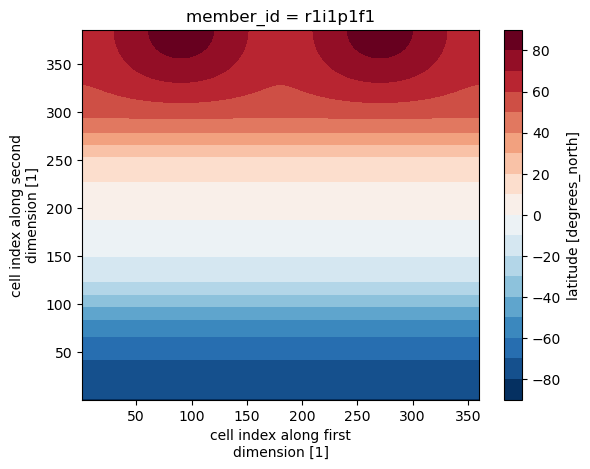

In [12]:
areacello.latitude.plot.contourf(levels = np.arange(-90,100,10))

### Select only the Northern Hemisphere (letting the Southern Hemisphere be Nans)

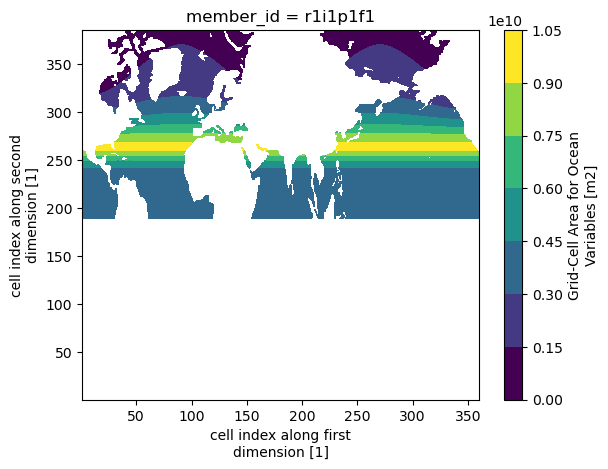

In [13]:
NHarea = areacello.areacello.where(areacello.latitude>0)
NHarea.plot.contourf()

### select only the Barents Sea 

   - Min. Lat	65° 52' 58" N (65.8828°)  
   - Min. Long	16° 34' 54.4" E (16.5818°)  
   - Max. Lat	81° 51' 4.4" N (81.8512°)  
   - Max. Long	68° 34' 41.7" E (68.5783°) 

<xarray.DataArray 'areacello' (j: 385, i: 360)>
dask.array<where, shape=(385, 360), dtype=float32, chunksize=(385, 360), chunktype=numpy.ndarray>
Coordinates:
  * i          (i) int32 1 2 3 4 5 6 7 8 9 ... 353 354 355 356 357 358 359 360
  * j          (j) int32 1 2 3 4 5 6 7 8 9 ... 378 379 380 381 382 383 384 385
    latitude   (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    member_id  <U8 'r1i1p1f1'
Attributes:
    cell_methods:   area: sum
    comment:        Horizontal area of ocean grid cells
    history:        2019-11-08T08:17:36Z altered by CMOR: Converted type from...
    long_name:      Grid-Cell Area for Ocean Variables
    original_name:  parea
    standard_name:  cell_area
    units:          m2

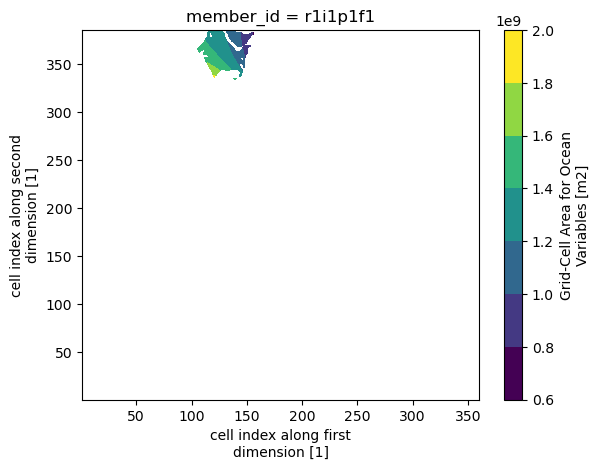

In [19]:
BSarea = areacello.areacello.where((areacello.latitude>=65.9) & (areacello.latitude<=81.9) & (areacello.longitude <= 68.6)  & (areacello.longitude >= 16.6))
BSarea.plot.contourf()
BSarea

## Lets read some sea surface data from the bucket and see how it looks
### The omip1 experiment contains 6 forcing cycles over 62 years, so we only read the last 62 years  

In [15]:
remote_files = 's3://escience2022/Ada/monthly/tos_Omon_NorESM2-LM_omip1_r1i1p1f1_gn_20*.nc'
remote_files = s3.glob(remote_files)
remote_files

['escience2022/Ada/monthly/tos_Omon_NorESM2-LM_omip1_r1i1p1f1_gn_200001-200912.nc',
 'escience2022/Ada/monthly/tos_Omon_NorESM2-LM_omip1_r1i1p1f1_gn_201001-201912.nc',
 'escience2022/Ada/monthly/tos_Omon_NorESM2-LM_omip1_r1i1p1f1_gn_202001-202912.nc',
 'escience2022/Ada/monthly/tos_Omon_NorESM2-LM_omip1_r1i1p1f1_gn_203001-203912.nc',
 'escience2022/Ada/monthly/tos_Omon_NorESM2-LM_omip1_r1i1p1f1_gn_204001-204912.nc',
 'escience2022/Ada/monthly/tos_Omon_NorESM2-LM_omip1_r1i1p1f1_gn_205001-205912.nc',
 'escience2022/Ada/monthly/tos_Omon_NorESM2-LM_omip1_r1i1p1f1_gn_206001-206912.nc',
 'escience2022/Ada/monthly/tos_Omon_NorESM2-LM_omip1_r1i1p1f1_gn_207001-207112.nc']

In [16]:
# Iterate through remote_files to create a fileset
fileset = [s3.open(file) for file in remote_files]
ds = xr.open_mfdataset(fileset, combine='by_coords')
ds

<xarray.Dataset>
Dimensions:             (time: 864, bnds: 2, j: 385, i: 360, vertices: 4)
Coordinates:
  * time                (time) object 2000-01-16 12:00:00 ... 2071-12-16 12:0...
  * j                   (j) int32 1 2 3 4 5 6 7 ... 379 380 381 382 383 384 385
  * i                   (i) int32 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
    latitude            (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    vertices_latitude   (time, j, i, vertices) float64 dask.array<chunksize=(120, 385, 360, 4), meta=np.ndarray>
    vertices_longitude  (time, j, i, vertices) float64 dask.array<chunksize=(120, 385, 360, 4), meta=np.ndarray>
    tos                 (time, j, i) float32 dask.array<chunksize=(120, 385, 360), meta=np.ndarray>
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               OMIP
    branch_method:             no parent
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     0.0
    ...                        ...
    title:                     NorESM2-LM output prepared for CMIP6
    variable_id:               tos
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.5.0
    tracking_id:               hdl:21.14100/d143b3bb-9d9d-48cc-bb96-bc0bd6b5a9a8

In [25]:
ds.tos

<xarray.DataArray 'tos' (time: 864, j: 385, i: 360)>
dask.array<concatenate, shape=(864, 385, 360), dtype=float32, chunksize=(120, 385, 360), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 2000-01-16 12:00:00 ... 2071-12-16 12:00:00
  * j          (j) int32 1 2 3 4 5 6 7 8 9 ... 378 379 380 381 382 383 384 385
  * i          (i) int32 1 2 3 4 5 6 7 8 9 ... 353 354 355 356 357 358 359 360
    latitude   (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Sea Surface Temperature
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    units:          degC
    original_name:  sst
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello
    history:        2019-10-06T21:54:18Z altered by CMOR: Converted type from...

In [53]:
month_length = ds.time.dt.days_in_month
weights = month_length.groupby("time.year") / month_length.groupby("time.year").sum()
# Test that the sum of the weights for each year is 1.0
np.testing.assert_allclose(weights.groupby("time.year").sum().values, np.ones(len(np.unique(ds.time.dt.year))))
# Calculate the weighted average:
da = (ds.tos * weights).groupby("time.year").sum(dim="time")
da

<xarray.DataArray (year: 72, j: 385, i: 360)>
dask.array<transpose, shape=(72, 385, 360), dtype=float64, chunksize=(1, 385, 360), chunktype=numpy.ndarray>
Coordinates:
  * j          (j) int32 1 2 3 4 5 6 7 8 9 ... 378 379 380 381 382 383 384 385
  * i          (i) int32 1 2 3 4 5 6 7 8 9 ... 353 354 355 356 357 358 359 360
    longitude  (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    latitude   (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
  * year       (year) int64 2000 2001 2002 2003 2004 ... 2068 2069 2070 2071

### Here we see that da contains data for 72 years, but we only need the last 62 years, so let's remove the first 10 years

In [54]:
da = da.isel(year = slice(10,None))
da

<xarray.DataArray (year: 62, j: 385, i: 360)>
dask.array<getitem, shape=(62, 385, 360), dtype=float64, chunksize=(1, 385, 360), chunktype=numpy.ndarray>
Coordinates:
  * j          (j) int32 1 2 3 4 5 6 7 8 9 ... 378 379 380 381 382 383 384 385
  * i          (i) int32 1 2 3 4 5 6 7 8 9 ... 353 354 355 356 357 358 359 360
    longitude  (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    latitude   (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
  * year       (year) int64 2010 2011 2012 2013 2014 ... 2068 2069 2070 2071

### Let's start with the global mean SST 
#### You need to use the area of the grid cells as weights

In [46]:
da_globalmean= (areacello.areacello*da).sum(dim=('i','j'), keep_attrs=True)/areacello.areacello.sum(dim=('i','j'))

In [52]:
da_globalmean.attrs['units'] = ds.tos.units

da_globalmean

<xarray.DataArray (year: 32)>
dask.array<truediv, shape=(32,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    member_id  <U8 'r1i1p1f1'
  * year       (year) int64 2040 2041 2042 2043 2044 ... 2068 2069 2070 2071
Attributes:
    units:    degC

#### plotting the global mean

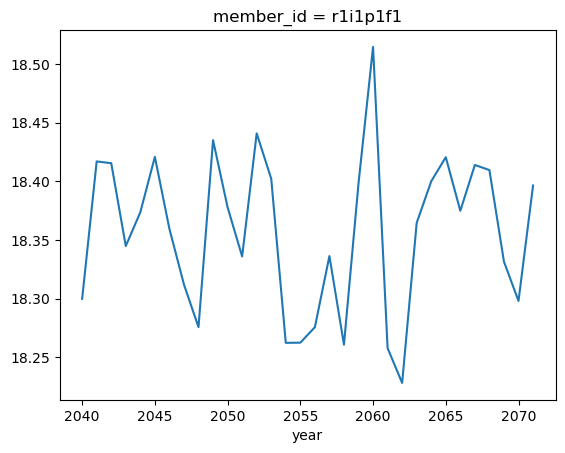

In [41]:
da_globalmean.plot(x='year')

### Then we continue with the Barents Sea

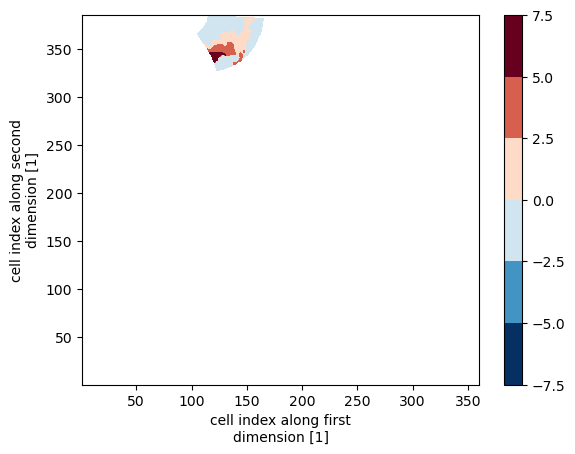

In [43]:
BSsst = da.where((da.latitude>=65.9) & (da.latitude<=81.9) & (da.longitude <= 68.6)  & (da.longitude >= 16.6))
BSsst.mean(dim='year').plot.contourf()

In [44]:
BSsst = (BSarea*BSsst).sum(dim=('i','j'))/BSarea.sum(dim=('i','j'))

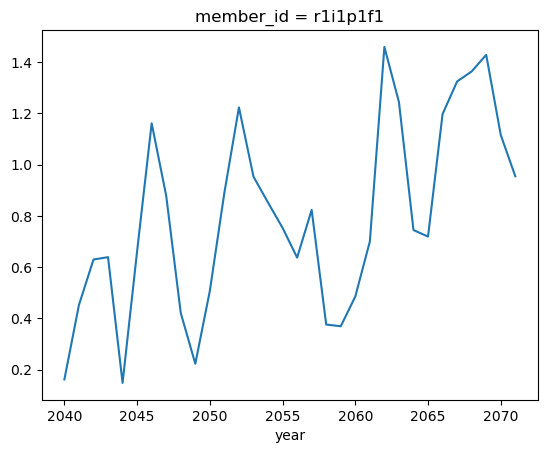

In [45]:
BSsst.plot(x='year')

In [55]:
da_monthly = ds.tos.groupby('time.month').mean(dim='time')
da_monthly

<xarray.DataArray 'tos' (month: 12, j: 385, i: 360)>
dask.array<transpose, shape=(12, 385, 360), dtype=float32, chunksize=(1, 385, 360), chunktype=numpy.ndarray>
Coordinates:
  * j          (j) int32 1 2 3 4 5 6 7 8 9 ... 378 379 380 381 382 383 384 385
  * i          (i) int32 1 2 3 4 5 6 7 8 9 ... 353 354 355 356 357 358 359 360
    longitude  (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    latitude   (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregations.py:258: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,


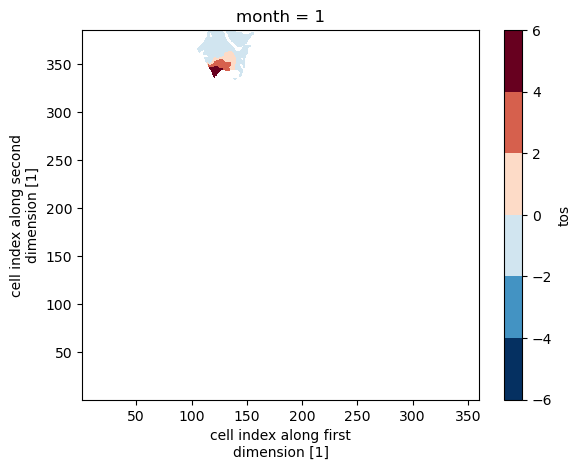

In [56]:
BS_monthly = da_monthly.where((da.latitude>=65.9) & (da.latitude<=81.9) & (da.longitude <= 68.6)  & (da.longitude >= 16.6))
BS_monthly.sel(month = 1).plot.contourf()

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregations.py:258: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,


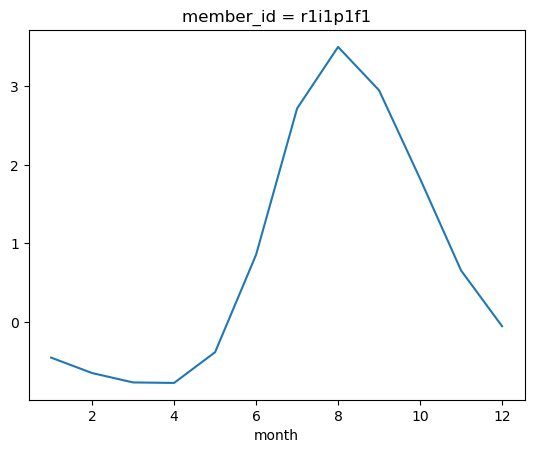

In [57]:
BS_monthly = (BSarea*BS_monthly).sum(dim=('i','j'))/BSarea.sum(dim=('i','j'))
BS_monthly.plot(x='month')